# Обучение нейросети для решения задачи классификации

## Официальное описание датасета

"We introduce a challenging data set of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels."

"Мы представляем сложный набор данных, состоящий из 101 категории продуктов питания и 101'000 изображений. Для каждого класса предоставлено 250 тестовых изображений, прошедших ручную проверку, а также 750 обучающих изображений. Учебные изображения специально не очищались и, таким образом, содержат некоторое количество шума. В основном это интенсивные цвета и иногда неправильные метки. Все изображения были изменены таким образом, чтобы максимальная длина стороны составляла 512 пикселей."

## Описание Датасета

Обучение будет происходить на основе датасета - Food-101!
- Количество классов: 101;
- Количество фотографий: 101.000;
- Распределение: равномерное по 250 фотографий *test* и 750 *train*;

## План
- [ ] Загрузить датасет и разделение на Test/Train;
- [ ] Аугментация изображений и борьба с шумом;
    - [ ] Изменение размера;
    - [ ] Случайный поворот;
    - [ ] Небольшой блюр;
    - [ ] Нормализация изображений;
    - [ ] Отзеркаливание изображений;
- [ ] Подбор гиперпараметров сети;
- [ ] Использование Transfer Learning на нейросети от компании Google - "";
- [ ] Сохранение весов модели для микросервиса;
- [ ] Возможность дообучения модели на новых данных;

# Импорт необходимых библиотек для обучения

In [ ]:
%matplotlib inline

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras import layers, models #, load_model
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Resizing, RandomFlip, RandomRotation

import numpy as np
import os

## Проверка GPU

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
mixed_precision.set_global_policy("mixed_float16")

TensorFlow version: 2.18.0
Num GPUs Available: 1


# Загрузка Dataset food-101

In [ ]:
# Загрузка данных
dataset, info = tfds.load(
    'food101',
    split=['train', 'validation'],
    with_info=True,
    shuffle_files=True,
    as_supervised=True,
    data_dir='/my_dataset'
)

In [ ]:
# Разделение на Test and Train
train_ds = dataset[0]
test_ds = dataset[1]

## Информация про датасет

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    split

## Информация про разделение

In [ ]:
print("Количество тренировочных примеров:", info.splits['train'].num_examples)
print("Количество классов:", info.features['label'].num_classes)

Количество тренировочных примеров: 75750
Количество классов: 101


# Конфигурация

In [ ]:
# Подготовка изображения
IMG_USING_RESIZE = True
IMG_USING_ROTATION = True
IMG_USING_BLUR = False
IMG_USING_NORMALIZATION = True
IMG_USING_MIRROR_LR = True
IMG_USING_MIRROR_TD = True

IMG_SIZE = 224
IMG_RESIZE = (IMG_SIZE, IMG_SIZE)

In [ ]:
# Параметры обучения
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 500
AUTOTUNE = tf.data.AUTOTUNE
UNFREEZE_LAST_LAYERS = True
CNT_LAST_LAYERS = 25
NUM_CLASSES = 101

In [ ]:
# Пути
MODEL_DIR = 'models'
MODEL_NAME = 'v1.keras'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME)

In [ ]:
# Другое
IMG_PREWIEW_COUNT = 3

# Методы обработки изображений

In [ ]:
data_augmentation = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.25),  # примерно соответствует 90° поворотам
    # Можно добавить RandomZoom или другие слои, если нужно размытие/изменение масштаба
])

In [ ]:
def img_preprocess(image, label, isTrain: bool = True):
    # Нормализация всегда
    image = tf.cast(image, tf.float32) / 255.0

    if IMG_USING_RESIZE and not isTrain:
        image = tf.image.resize(image, IMG_RESIZE)
    elif isTrain:
        # Для тренировочного набора можно встроить аугментации
        image = data_augmentation(image)
    return image, label


# def img_preprocess(image, label, isTrain: bool = True):
#     if IMG_USING_RESIZE:
#         image = tf.image.resize(image, IMG_RESIZE)

#     # Аугментации
#     if isTrain:
#         if IMG_USING_ROTATION:
#             # Случайный поворот на 0°, 90°, 180° или 270°
#             image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

#         if IMG_USING_MIRROR_LR:
#             image = tf.image.random_flip_left_right(image)
#         if IMG_USING_MIRROR_TD:
#             image = tf.image.random_flip_up_down(image)

#         if IMG_USING_BLUR:
#             # Размытие через уменьшение/увеличение размера
#             image = tf.image.resize(
#                 tf.image.resize(image, [64, 64]),
#                 IMG_RESIZE
#             )

#     # Нормализация [0, 1]
#     if IMG_USING_NORMALIZATION:
#         image = image / 255.0

#     return image, label

In [ ]:
# Пайплайн для тренировочных данных
# train_ds = train_ds.map(
#     lambda x, y: img_preprocess(x, y, isTrain=True),
#     num_parallel_calls=AUTOTUNE
# ).cache(  # Кэшируем после препроцессинга
#     filename='./train_cache'  # Сохраняем кэш на диск для больших данных
# ).shuffle(
#     SHUFFLE_BUFFER_SIZE,
#     reshuffle_each_iteration=True  # Перемешиваем каждую эпоху
# ).batch(
#     BATCH_SIZE,
#     num_parallel_calls=AUTOTUNE
# ).prefetch(AUTOTUNE)

train_ds = train_ds.map(
    lambda x, y: img_preprocess(x, y, isTrain=True),
    num_parallel_calls=AUTOTUNE
).shuffle(
    SHUFFLE_BUFFER_SIZE,
    reshuffle_each_iteration=True  # Перемешиваем каждую эпоху
).batch(
    BATCH_SIZE
    # ,num_parallel_calls=AUTOTUNE
).repeat().prefetch(1)

# Пайплайн для тестовых данных
# test_ds = test_ds.map(
#     lambda x, y: img_preprocess(x, y, isTrain=False),
#     num_parallel_calls=AUTOTUNE
# ).cache('./test_cache').batch(
#     BATCH_SIZE,
#     num_parallel_calls=AUTOTUNE
# ).prefetch(AUTOTUNE)

test_ds = test_ds.map(
    lambda x, y: img_preprocess(x, y, isTrain=False),
    num_parallel_calls=AUTOTUNE
).batch(
    BATCH_SIZE
    # ,num_parallel_calls=AUTOTUNE
).prefetch(1)

In [ ]:
def show_augmented_samples(dataset, num_samples=3):
    plt.figure(figsize=(15, 5))
    # Итерируемся непосредственно по батчам
    for i, batch in enumerate(dataset.take(1)):  # Берем один батч
        images, labels = batch
        # Отображаем первые num_samples изображений из батча
        for j in range(min(num_samples, images.shape[0])):
            image = images[j].numpy()
            label = labels[j].numpy()

            # Денормализация
            if IMG_USING_NORMALIZATION:
                image = image * 255.0

            # Конвертация в uint8
            image = image.astype('uint8')

            # Обработка ч/б изображений
            if image.shape[-1] == 1:
                image = image.squeeze(axis=-1)
                cmap = 'gray'
            else:
                cmap = None

            plt.subplot(1, num_samples, j+1)
            plt.imshow(image, cmap=cmap)
            plt.title(f'Label: {label}')
            plt.axis('off')
        break  # Прерываем после первого батча

    plt.tight_layout()
    plt.show()

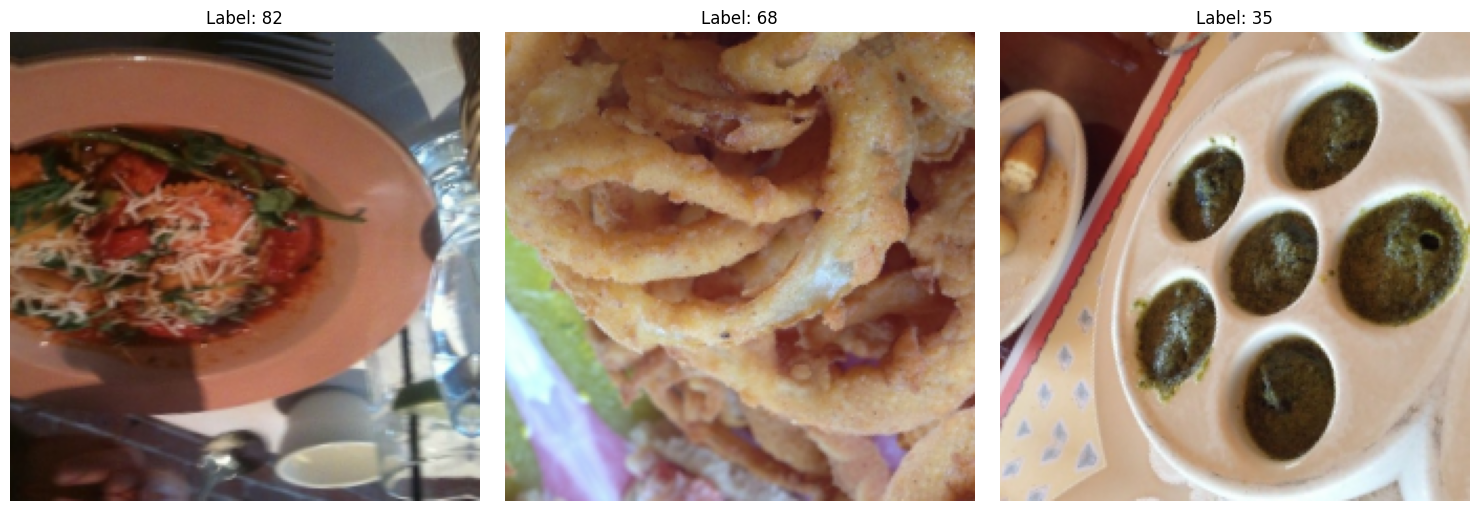

In [ ]:
# Пример использования:
# Для тренировочных данных (с батчингом)
show_augmented_samples(train_ds, IMG_PREWIEW_COUNT)

In [ ]:
# Для тестовых данных
# show_augmented_samples(test_ds, IMG_PREWIEW_COUNT)

# Построение модели

In [ ]:
def create_model():
    # Загрузка предобученной модели без верхних слоев
    # base_model = EfficientNetB0(
    #     include_top=False,
    #     weights='imagenet',
    #     input_shape=(IMG_SIZE, IMG_SIZE, 3)
    # )

    # Загрузка предобученной модели ResNet50 без верхних слоев
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Заморозка всех слоев, затем разморозка последних N слоев при необходимости
    base_model.trainable = False
    if UNFREEZE_LAST_LAYERS:
        for layer in base_model.layers[-CNT_LAST_LAYERS:]:
            layer.trainable = True

    # Создание входного слоя
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    # Получение признаков из базовой модели
    x = base_model(inputs, training=False)
    # Глобальный пуллинг
    x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Flatten()(x)
    # Полносвязный слой
    x = layers.Dense(512, activation='relu')(x)
    # Dropout для регуляризации
    x = layers.Dropout(0.5)(x)
    # Выходной слой
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x)
    # outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = create_model()


In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_3 (Cast)                   │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │        51,813 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,688,613 (94.18 MB)

 Trainable params: 10,032,229 (38.27 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [ ]:
model.compile(
    optimizer=mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam(learning_rate=3e-5)),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Загрузка уже обученных весов
# model.load_weights('v.weights.h5')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer_3', because it has 4 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 58 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Добавление Callback'ов

In [ ]:
# EarlyStopping — завершает обучение, если выбранная метрика (например, val_loss) не улучшается в течение заданного количества эпох.
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint — сохраняет модель с лучшими показателями на валидации.
model_checkpoint = ModelCheckpoint(
    filepath='v.weights.h5',
    monitor='val_loss',
    # save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# ReduceLROnPlateau — уменьшает learning rate, если выбранная метрика не улучшалась некоторое время.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

## Обучение модели

In [ ]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=500,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0443 - loss: 4.3757
Epoch 1: saving model to .weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 842s 2s/step - accuracy: 0.0443 - loss: 4.3757 - val_accuracy: 0.0687 - val_loss: 4.2322 - learning_rate: 3.0000e-05
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0563 - loss: 4.2947
Epoch 2: saving model to .weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 805s 2s/step - accuracy: 0.0563 - loss: 4.2946 - val_accuracy: 0.0658 - val_loss: 4.2000 - learning_rate: 3.0000e-05
Epoch 3/5
459/500 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.0675 - loss: 4.2291

KeyboardInterrupt: 

## Сохранение модели

In [ ]:
# model.save(MODEL_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'models/v1.keras'

In [ ]:
# Извлечение истории обучения
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Построение графика
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Точность
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Train & Validation Accuracy')

# Потери
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train & Validation Loss')

plt.tight_layout()
plt.show()